In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor


Load Data

In [3]:
df = pd.read_parquet("processed_data/final_with_anomalies.parquet")
df["Date"] = pd.to_datetime(df["Date"])

df.shape


(421570, 29)

Merge Store–Dept Clustering

In [4]:
store_dept_clusters = pd.read_parquet(
    "processed_data/store_dept_segmentation/store_dept_seg.parquet"
)

store_dept_clusters = store_dept_clusters[
    ["Store", "Dept", "Cluster_KMeans4"]
].rename(columns={"Cluster_KMeans4": "Cluster_SD"})

df = df.merge(
    store_dept_clusters,
    on=["Store", "Dept"],
    how="left"
)

assert df["Cluster_SD"].isnull().sum() == 0


Sort Data

In [6]:
df = df.sort_values(["Store", "Dept", "Date"]).reset_index(drop=True)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Rolling_Std_4,Z_Score,Pct_Deviation,Lag_1,Type_B,Type_C,IF_Anomaly,LOF_Anomaly,High_Confidence_Anomaly,Cluster_SD
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,...,0.000000,NaN,0.000000,24924.50,False,False,0,0,0,1
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,...,14930.552614,0.707107,0.297545,24924.50,False,False,1,0,0,1
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,...,11131.900957,0.366128,0.108628,46039.49,False,False,0,0,0,1
3,1,1,2010-02-26,19403.54,0,46.63,2.561,0.0,0.0,0.0,...,12832.106391,-1.058846,-0.411849,41595.55,False,False,0,0,0,1
4,1,1,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,0.0,...,13554.047185,-0.766466,-0.322465,19403.54,False,False,0,0,0,1


Feature Engineering for Forecasting

In [7]:
# Additional lag features (experimenting)

df["Lag_4"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(4)
df["Lag_52"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(52)


In [8]:
df.isnull().sum()

Store                           0
Dept                            0
Date                            0
Weekly_Sales                    0
IsHoliday                       0
Temperature                     0
Fuel_Price                      0
MarkDown1                       0
MarkDown2                       0
MarkDown3                       0
MarkDown4                       0
MarkDown5                       0
CPI                             0
Unemployment                    0
Size                            0
Has_Markdown                    0
Week                            0
Month                           0
Year                            0
Rolling_Mean_4                  0
Rolling_Std_4                   0
Z_Score                      3499
Pct_Deviation                   0
Lag_1                           0
Type_B                          0
Type_C                          0
IF_Anomaly                      0
LOF_Anomaly                     0
High_Confidence_Anomaly         0
Cluster_SD    

Handling Missing Values in Lag Features (Rolling Mean Based Imputation)

In [9]:
# No leakage prone statistics (like global mean)

df["Lag_4"] = df["Lag_4"].fillna(df["Rolling_Mean_4"])
df["Lag_52"] = df["Lag_52"].fillna(df["Rolling_Mean_4"])


In [10]:
target = "Weekly_Sales"

features_base = [
    "Lag_1",
    "Rolling_Mean_4",
    "Rolling_Std_4",
    "IsHoliday",
    "Has_Markdown",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Cluster_SD"
]



In [11]:
features_extended = features_base + ["Lag_4", "Lag_52"]


In [12]:
last_date = df["Date"].max()
split_date = last_date - pd.Timedelta(weeks=12)

train_df = df[df["Date"] <= split_date].copy()
test_df  = df[df["Date"] > split_date].copy()

train_df.shape, test_df.shape


((386007, 32), (35563, 32))

In [13]:
def evaluate_forecast(train_df, test_df, feature_cols, label):
    X_train = train_df[feature_cols]
    y_train = train_df[target]

    X_test = test_df[feature_cols]
    y_test = test_df[target]

    # Baseline
    baseline_pred = test_df["Rolling_Mean_4"]

    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    baseline_rmse = root_mean_squared_error(y_test, baseline_pred)

    # ML model
    model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    )
    model.fit(X_train, y_train)
    ml_pred = model.predict(X_test)

    ml_mae = mean_absolute_error(y_test, ml_pred)
    ml_rmse = root_mean_squared_error(y_test, ml_pred)

    print(f"\n===== {label} =====")
    print(f"Baseline MAE : {baseline_mae:.2f}")
    print(f"Baseline RMSE: {baseline_rmse:.2f}")
    print(f"ML MAE       : {ml_mae:.2f}")
    print(f"ML RMSE      : {ml_rmse:.2f}")

    return test_df.assign(
        Pred_ML=ml_pred,
        Pred_Baseline=baseline_pred
    )


Experiment 1 — Base Features

In [14]:
results_base = evaluate_forecast(
    train_df,
    test_df,
    features_base,
    "Experiment 1: Base Features"
)



===== Experiment 1: Base Features =====
Baseline MAE : 1179.75
Baseline RMSE: 2685.99
ML MAE       : 1186.18
ML RMSE      : 2628.83


Experiment 2 — Extended Lags

In [15]:
results_extended = evaluate_forecast(
    train_df,
    test_df,
    features_extended,
    "Experiment 2: Extended Lag Features"
)



===== Experiment 2: Extended Lag Features =====
Baseline MAE : 1179.75
Baseline RMSE: 2685.99
ML MAE       : 1103.25
ML RMSE      : 2394.84


Cluster-wise Error Analysis

In [ ]:
# Error Analysis by Cluster - Absolute Error Comparison between ML model and Rolling Mean Baseline for Experiment 1 

results_base["AE_ML"] = abs(results_base[target] - results_base["Pred_ML"])
results_base["AE_Baseline"] = abs(results_base[target] - results_base["Pred_Baseline"])

cluster_error = (
    results_base
    .groupby("Cluster_SD")[["AE_ML", "AE_Baseline"]]
    .mean()
)

cluster_error


,AE_ML,AE_Baseline
Cluster_SD,,
0,3186.331975,3257.729170
1,2646.967020,2661.521789
2,611.322163,594.022382
3,142.721251,18.353761


In [17]:
# Error Analysis by Cluster - Absolute Error Comparison between ML model and Rolling Mean Baseline for Experiment 2 

results_extended["AE_ML"] = abs(results_extended[target] - results_extended["Pred_ML"])
results_extended["AE_Baseline"] = abs(results_extended[target] - results_extended["Pred_Baseline"])
cluster_error_ext = (
    results_extended
    .groupby("Cluster_SD")[["AE_ML", "AE_Baseline"]]
    .mean()
)
cluster_error_ext

,AE_ML,AE_Baseline
Cluster_SD,,
0,2938.765444,3257.729170
1,2408.053712,2661.521789
2,586.627497,594.022382
3,194.425290,18.353761


Visual Forecast

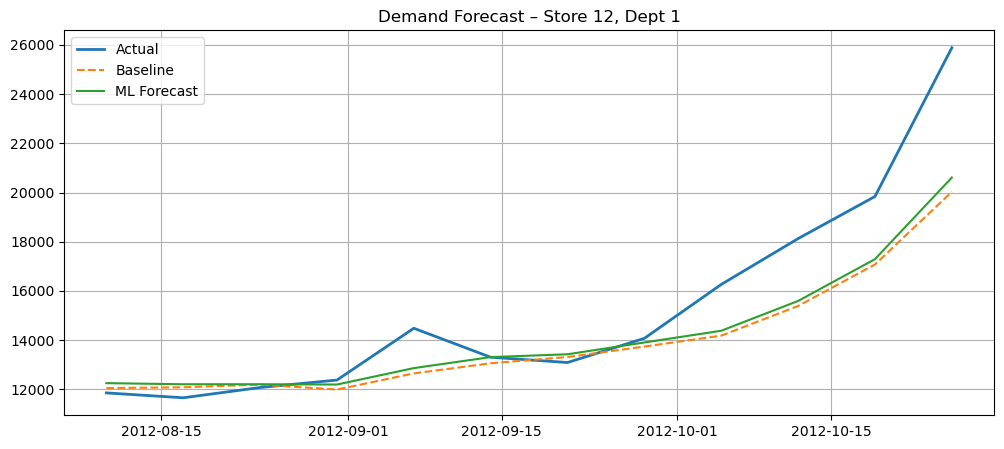

In [18]:
# Visualize Actual vs Predicted for a Sample Store-Dept(12, 1)


sample = results_base[
    (results_base["Store"] == 12) &
    (results_base["Dept"] == 1)
]

plt.figure(figsize=(12,5))
plt.plot(sample["Date"], sample["Weekly_Sales"], label="Actual", linewidth=2)
plt.plot(sample["Date"], sample["Pred_Baseline"], "--", label="Baseline")
plt.plot(sample["Date"], sample["Pred_ML"], label="ML Forecast")
plt.title("Demand Forecast – Store 12, Dept 1")
plt.legend()
plt.grid(True)
plt.show()


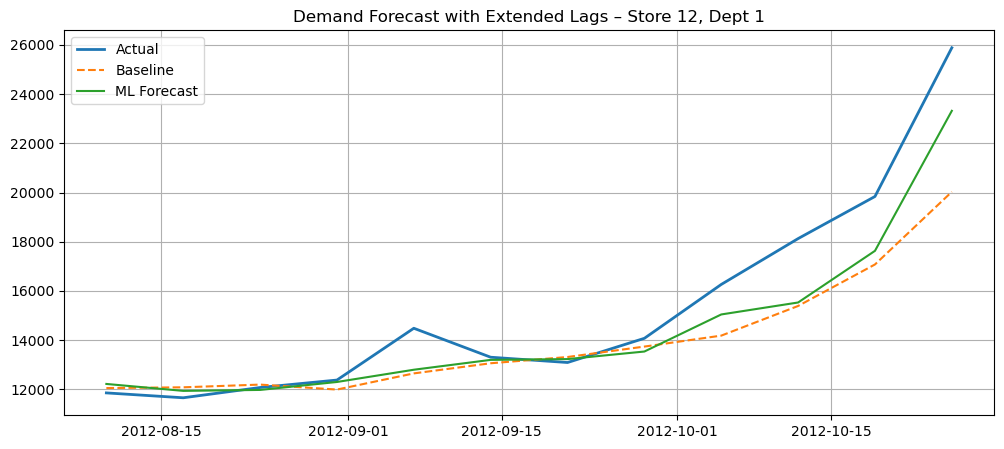

In [19]:
# Visualize Actual vs Predicted for a Sample Store-Dept(12, 1) for Experiment 2
sample_ext = results_extended[
    (results_extended["Store"] == 12) &
    (results_extended["Dept"] == 1)
]
plt.figure(figsize=(12,5))
plt.plot(sample_ext["Date"], sample_ext["Weekly_Sales"], label="Actual", linewidth=2)
plt.plot(sample_ext["Date"], sample_ext["Pred_Baseline"], "--", label="Baseline")
plt.plot(sample_ext["Date"], sample_ext["Pred_ML"], label="ML Forecast")
plt.title("Demand Forecast with Extended Lags – Store 12, Dept 1")
plt.legend()    
plt.grid(True)
plt.show()


Anomaly Impact on Forecast Errors

In [20]:
# anomaly impact for Experiment 1
anomaly_impact = (
    results_base
    .groupby("High_Confidence_Anomaly")[["AE_ML", "AE_Baseline"]]
    .mean()
)

anomaly_impact


,AE_ML,AE_Baseline
High_Confidence_Anomaly,,
0,1179.949133,1174.370465
1,9696.498387,8532.403558


In [21]:
# anomaly Impact for Experiment 2
anomaly_impact_ext = (
    results_extended
    .groupby("High_Confidence_Anomaly")[["AE_ML", "AE_Baseline"]]
    .mean()
)
anomaly_impact_ext

,AE_ML,AE_Baseline
High_Confidence_Anomaly,,
0,1100.474840,1174.370465
1,4893.522143,8532.403558
